**Final Project: Overdamped and Markovian Langevin Equation**

Frédéric Sonak

This markdown was created with the assistance of ChatGPT, focusing on grammar, spelling, and readability.

**Background**

Systems where the timescale along the system coordinate is significantly slower than all other motions in the simulation, a Langevin equation may be used to model the system. In this Task a one dimensionsal particle, described by its position x(t) is considered. A potential U(x) defines the systems landscape and ensures that no boundarys need to be set by being defined to havin exploding potentials for large and small x values. Therefore the single particle should only live within a specified range. In this example a double well potential is used. This system, also known as Kramers' escape Problem is commonly used to study bistable systems found in chemical reaction or rate theories.

Simulations such as this one can also be found, in one way or another, in the modelling of energy landscapes. Commonly used in nucleation dynamics or protein folding simulations, can make use of one dimensional potentials and a variety of functions exploring these potentials to run simulations. This reminds me of my the term paper presentation on "Determining biological process rates via metdynamics".

The Project is structured into three tasks. In the first Task a Markovian Langevin Equation is implemented as an integrator. Using given variables and constants a simulation is run. The trajectory of the particle is visualised a histogramm shows the position distribution after the simulation. The positions are then assigned two states "Left" and "Right". From these the transition rates between the two states can be calculated.

In Task two the Markovian Langevin Equation is switched for an overdamped langevin equation. Again an exemplary trajectory is visualised, a histogram computed and the transition rates calculated. At this point the transition rates derived through the two different ways can be compared.

And Finally both Langevin simulations are run for different damping coefficients revealing the coefficient at which both simulations yield similar results. The so determined transition rates are then finally compared with theoretically calculated transition rates.



We begin by importing all libraries used in this code.

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import time
import plotly.graph_objects as go

**Task 1: Implement Markovian Langevin Equation**


To describe the dynamics by the Markovian Langevin equation the following integrator is implemented:

$
x(t + \Delta t) = x(t) + v(t) \Delta t
$

with the velocity given by

$
v(t + \Delta t) = v(t) - \frac{1}{m} \frac{dU (x(t))}{dx} \Delta t - \frac{1}{m} \Gamma v(t) \Delta t + \frac{1}{m} \sqrt{2k_B T \Gamma \Delta t R (t)}
$

In contrast to the excercise sheet (Sheet 10) on which this code is based, the potential is not constant but given as a double well:

$
U(x) = k_B T (0.28(0.25x^4 + 0.1x^3 - 3.24x^2) + 3.5)
$.

To get an overview of the potential it is defined below, deriviatives are calculated (as they are needed later on).  Deriviatives can be generated manually (by hand or using existing software). In Python the library "sympy" can be used. As Sympy however does not differentiate a classical function in python, as it is interpreted as a numerical function rather than a symbolic expression, an example of how to use symbolic functions in python with sympy is given at the very end. In the code below the deriviatives are simply defined for better readability.

In [2]:
# define potential and deriviatives

# As later on k_B * T is set to 38 only one variable:
# k_B_x_T = k_B * T is introduced

def U(x, k_B_x_T):
    return k_B_x_T * (0.28 * (0.25 * x**4 + 0.1 * x**3 - 3.24 * x**2) + 3.5)


def dU_dx(x, k_B_x_T):
    return  k_B_x_T * x * (0.28 * x**2 + 0.084 * x - 1.8144)

# needed for task 3
def ddU_ddx(x, k_B_x_T):
    return k_B_x_T * (0.84 * x**2 + 0.168 * x - 1.8144)

Next the potential is quickly visualised to aid with the understanding of the system.

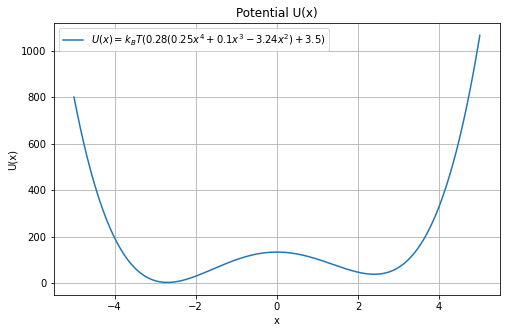

In [3]:
# Define x range
x = np.linspace(-5, 5, 500)

# Compute U(x), dU_dx, ddU_ddx using the above definitions
# and the given value of kB * T = 38 ps^-1
U_values = U(x, 38)
dU_dx_values = dU_dx(x, 38)
ddU_ddx_values = ddU_ddx(x, 38)

# plot using plt
plt.figure(figsize=(8, 5))
plt.plot(x, U_values, label=r"$U(x) = k_B T (0.28(0.25x^4 + 0.1x^3 - 3.24x^2) + 3.5)$")

plt.xlabel("x")
plt.ylabel("U(x)")
plt.title("Potential U(x)")
plt.legend()
plt.grid(True)

plt.show()

We can see a double well potential with a left minimum at x = -2.7 and a right minimum at x = 2.4. The maximum separating the minima is located at x = 0. It can also already be observed that the left minimum ist slightly lower than the right minimum. This will play an important part later on.

Now the integrator based on the above functions can be implemented. The following code is thus based on the similar integrator from sheet 10.

In [4]:

def langevin_integrator(steps, dt, x0, v0, mass, gamma, k_B_x_T, verbose=False):

    # for debugging
    if verbose:
        print("Running Langevin integrator with the following parameters:")
        print(f'steps: {steps}')
        print(f'dt: {dt}')
        print(f'x0: {x0}')
        print(f'v0: {v0}')
        print(f'mass: {mass}')
        print(f'gamma: {gamma}')

    # Initialise position and velocity arrays
    positions = np.zeros((steps))
    velocities = np.zeros((steps))

    # Set initial position and velocity
    positions[0] = x0
    velocities[0] = v0

    # calculate constants outside of loop to remove redundant calculations
    # This was found to speed up the calculations by about 20 % for large loops
    const_1 = gamma * dt / mass
    const_2 = np.sqrt(2  * k_B_x_T * gamma *  dt) / mass


    # Integration loop
    loop_range = range(steps - 1)

    for i in loop_range:
        # Generate Gaussian random number (zero mean, 1 variance)
        R = np.random.normal(0, 1)  # Generate a single random number

        # Current velocity and position
        v = velocities[i]
        x = positions[i]

        # Update velocity using Langevin equation
        v_next = v + (-dU_dx(x, k_B_x_T) / mass) * dt - const_1 * v + const_2 * R

        # Update position
        x_next = x + v_next * dt

        # Store the updated values
        velocities[i + 1] = v_next
        positions[i + 1] = x_next

        # Debugging: Check if x, v, force, or noise is growing too fast
        # this was implemented as during the programming of this code I had multiple issues with exploding forces and subsequently exploding positions x
        if verbose:
            if i % (steps // 10) == 0:  # Print 10 times throughout simulation
                print(f"Step {i}: x = {x_next:.5f}, "
                      f"v = {v_next:.5f}, force = {-dU_dx(x, k_B_x_T):.2f} noise = {R:.5f}")


    return positions, velocities

This integrator can now be used to run a simulation with the given Parameters from the task sheet. To speed up the calculations during debugging the steps number can be reduced by 100-1000 steps.

In [5]:
#run simulation with given parameters from task sheet

gamma = 100         # no unit
k_B_x_T = 38          # Bolzmann consant times temperature # ps^-1
dt = 0.001            # Time step size # ps
steps = 50 * 10**6         # smaller number of time steps
mass = 1                # mass in ps
x0 = 0                 # Initial position, no unit
v0 = 0                 # Initial velocity, in ps^-1


# Run simulation
positions_markovian, velocities_markovian = langevin_integrator(steps, dt, x0, v0, mass, gamma, k_B_x_T, verbose=True)

Running Langevin integrator with the following parameters:
steps: 50000000
dt: 0.001
x0: 0
v0: 0
mass: 1
gamma: 100
Step 0: x = -0.00077, v = -0.77119, force = 0.00 noise = -0.27974
Step 5000000: x = -2.90710, v = 2.67932, force = 34.49 noise = -1.36038
Step 10000000: x = -1.81504, v = -3.35984, force = -72.12 noise = 0.49465
Step 15000000: x = -3.41130, v = 1.06583, force = 150.33 noise = 0.30290
Step 20000000: x = 1.37687, v = 1.16569, force = 61.11 noise = 0.16699
Step 25000000: x = -2.64414, v = 6.57644, force = -7.02 noise = 1.00096
Step 30000000: x = 1.81382, v = -3.78551, force = 50.88 noise = -0.03429
Step 35000000: x = -1.74792, v = -6.98326, force = -73.56 noise = 0.53777
Step 40000000: x = -2.84823, v = -8.42003, force = 22.14 noise = -0.33901
Step 45000000: x = -0.79289, v = -4.39043, force = -51.13 noise = -1.14870


A quick look at the debugging information reveals that the simulations is stable over the chosen parameters with no exploding values.
To further investigate this, the results are plotted.

/Users/fsonak/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


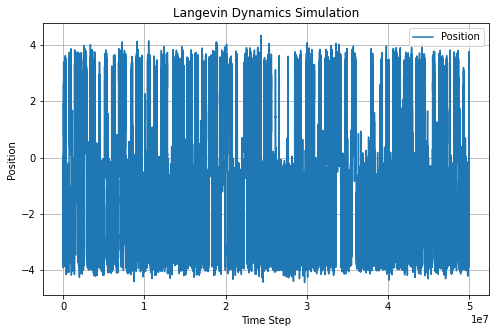

In [6]:
# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(np.arange(steps), positions_markovian, label="Position")
plt.xlabel("Time Step")
plt.ylabel("Position")
plt.title("Langevin Dynamics Simulation")
plt.legend()
plt.grid(True)
plt.show()

We can see clearly how two states corresponding to the two minimas from the potential at about x = -2.7 and x = 2.4 are explored. Also, multiple jumps from one minimum to the other can be seen as the simulation progresses.

To further quantify this a histogram of the positions can be calculated.

This can then be compared to a theoretical bolzmann distribution.

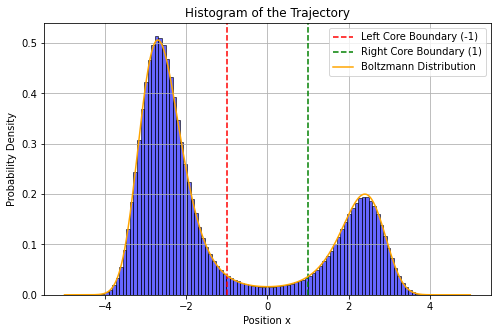

In [7]:
# Plot histogram of the trajectory
plt.figure(figsize=(8, 5))
plt.hist(positions_markovian, bins=100, density=True, color="blue", alpha=0.6, edgecolor="black")

# Mark core state boundaries
plt.axvline(-1, color="red", linestyle="--", label="Left Core Boundary (-1)")
plt.axvline(1, color="green", linestyle="--", label="Right Core Boundary (1)")





# The next part is simply for visualising the Bolzmann distribution for the correct potential

# Define the Boltzmann distribution P(x) ∝ exp(-U(x) / k_B T)
def boltzmann_distribution(x, k_B_x_T):
    P_x = np.exp(-U(x, k_B_x_T) / k_B_x_T)
    return P_x / np.trapz(P_x, x)  # Normalise by dividing through the integration of the Boltzmann distribution

# Compute theoretical Boltzmann distribution
P_x = boltzmann_distribution(x, k_B_x_T)

plt.plot(x, P_x, label="Boltzmann Distribution", color="orange")

plt.xlabel("Position x")
plt.ylabel("Probability Density")
plt.title("Histogram of the Trajectory")
plt.legend()
plt.grid(True)
plt.show()

The histogram looks very good. We can clearly see the two peaks corresponding to the two minima in the potential. As the probabilities towards large and small positions vanish the integrator appears stable.

Next the particles need to be assigned the core states left, or right. For consistency the inital state (x = 0) is simply assigned "left".
If a particle is positioned at $x < -1 $ the state left is assigned. For particles at $x > 1$ the state right is assigned.
The two states are implemented through assigning the values 0 for left and 1 for right.
For particles that lie between the two boarders the last visited state is assigned.

In [8]:
# defining the assign state function
def assign_core_states(positions):
    """
    Assigns each position in the trajectory to either the 'left' or 'right' state.
    Uses the last visited state for intermediate points (-1 < x < 1).
    """
    states = np.zeros(len(positions), dtype=int)  # 0 = left, 1 = right
    current_state = 0  # Assume starting in "left" (x(0) = 0)

    for i in range(len(positions)):
        x = positions[i]
        if x < -1:
            current_state = 0  # Left
        elif x > 1:
            current_state = 1  # Right
        # If -1 <= x <= 1, keep the last assigned state

        states[i] = current_state  # Store the state

    return states

In [9]:
# running the assign state function for the Langevin simulation
states_markovian = assign_core_states(positions_markovian)

To check the state assignment a quick statistics check can be used. Here we just count left and right states and see if they add up. Thus it can be assured that no double assignment took place.

In [10]:
def quick_statistics_check(states, verbose=True):
    # Count occurrences of left (0) and right (1) states
    left_count = np.sum(states == 0)
    right_count = np.sum(states == 1)

    # Total simulations
    total_simulations = len(states)

    # Check if the sum is correct
    sum_check = left_count + right_count == total_simulations

    # Print results
    if verbose:
        print(f"Left states (0): {left_count} = {left_count/total_simulations*100}%")
        print(f"Right states (1): {right_count} = {right_count/total_simulations*100}%")
        print(f"Total states: {total_simulations}")
        print(f"Check if both add up correctly: {'Yes' if sum_check else 'No'}")

    return left_count, right_count



In [11]:
count_left_right_markovian, count_right_left_markovian  = quick_statistics_check(states_markovian)

Left states (0): 35326687 = 70.653374%
Right states (1): 14673313 = 29.346625999999997%
Total states: 50000000
Check if both add up correctly: Yes


On a first check this seems correct, as the left minimum of the potential is lower than the right. Therefore, it makes sense that the systems is found more often in the left state. No double counting seems to have taken place.

Next, the transitions from left to right are counted. These numbers are called $\mathrm{N_{left\rightarrow right}}$ and $\mathrm{N_{right\rightarrow left}}$. The rate $\mathrm{k_{left\rightarrow right}}$ is given by:

$
\mathrm{k_{left\rightarrow right}} = \frac{\mathrm{N_{left\rightarrow right}}}{\mathrm{N_{left} \cdot \Delta t}}
$

Similarly the rate $\mathrm{k_{right\rightarrow left}}$ can be calculated.


In [12]:
def compute_transition_rates(states, left_count, right_count, verbose=True):
    # Count transitions from left (0) to right (1) and vice versa
    N_left_to_right = np.sum((states[:-1] == 0) & (states[1:] == 1))
    N_right_to_left = np.sum((states[:-1] == 1) & (states[1:] == 0))

    # Compute transition rates
    k_left_to_right = N_left_to_right / (left_count * dt)
    k_right_to_left = N_right_to_left / (right_count * dt)

    # Print results
    if verbose:
        print(f"Transition rate k(left -> right): {k_left_to_right:.5f} per ps")
        print(f"Transition rate k(right -> left): {k_right_to_left:.5f} per ps")

    return k_left_to_right, k_right_to_left


In [13]:
k_left_to_right_langevin,k_right_to_left_langevin = compute_transition_rates(states_markovian, count_left_right_markovian, count_right_left_markovian, verbose=True)

Transition rate k(left -> right): 0.00495 per ps
Transition rate k(right -> left): 0.01186 per ps


And to finish off task one an exemplary trajectory piece x(t) is show that shows a change from one state to another.

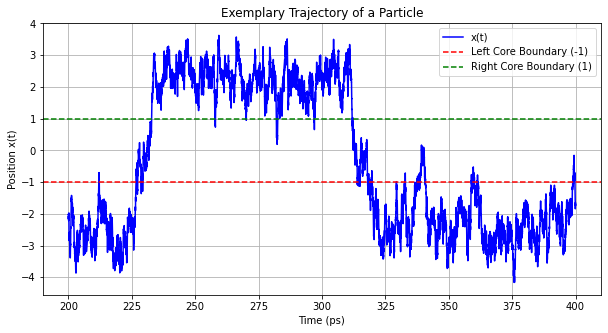

In [14]:
# Define example trajectory interval
# The interval is chosen from the above plot to show
# a relevant area of change of states

start_index = 200000
end_index = 400000

# Generate time array
time_array = np.arange(start_index, end_index) * dt

# Plot the trajectory
plt.figure(figsize=(10, 5))
plt.plot(time_array, positions_markovian[start_index:end_index], label="x(t)", color="blue")

# Mark core state boundaries
plt.axhline(-1, color="red", linestyle="--", label="Left Core Boundary (-1)")
plt.axhline(1, color="green", linestyle="--", label="Right Core Boundary (1)")

plt.xlabel("Time (ps)")
plt.ylabel("Position x(t)")
plt.title("Exemplary Trajectory of a Particle")
plt.legend()
plt.grid(True)
plt.show()

**Task 2: Implement overdamped Langevin equation**

Du to large friction, in some cases, the acceleration can be neglected i.e. $\frac{dv}{dx} \approx 0$. Thus, the integrator of the position changes to

$
x(t + \Delta t) = x(t) - \frac{1}{m} \frac{1}{\Gamma} \frac{dU(x(t))}{dx} \Delta t
+ \frac{1}{m} \sqrt{\frac{2k_B T \Delta t}{\Gamma}} R(t)
$

For this the above simulation is rerun with the same conditions to compare the results.
First the overdamped Langevin Integrator is implemented.

In [15]:
#TODO Do i need to remove mass? It doesnt make a numerical differnce as the variable is one, but in theory the overdamped langevin equation inertia is neglegible so mass should vanish, right?


def overdamped_langevin_integrator(steps, dt, x0, mass, gamma, k_B_x_T, verbose=False):
    if verbose:
        print(f' Running overdamped langevin integration with the following parameters:')
        print(f' steps: {steps}')
        print(f' dt: {dt}')
        print(f' x0: {x0}')
        print(f' mass: {mass}')
        print(f' gamma: {gamma}')
        print(f' k_B_x_T: {k_B_x_T}')

    # Initialize position array
    positions = np.zeros(steps)

    # Set initial position
    positions[0] = x0

    # Precompute noise scaling factor
    sqrt_2kBT_dt_gamma = np.sqrt(2 * k_B_x_T * dt / gamma)

    # Integration loop
    loop_range = range(steps - 1)

    for i in loop_range:
        # Generate Gaussian noise (zero mean, unit variance)
        noise = np.random.normal(0, 1)

        # current position
        x = positions[i]

        # Compute force (minus is included here!)
        force = -dU_dx(positions[i], k_B_x_T)

        x_next = x + (force / (gamma* mass)) * dt + (1/mass) * sqrt_2kBT_dt_gamma * noise

        # Store the updated value
        positions[i+1] = x_next


        # Debugging to check if variables explode
        if verbose:
            if i % (steps // 10) == 0:  # Print 10 times throughout simulation
                print(f"Step {i}: x = {positions[i + 1]:.5f}, force = {force:.2f}, noise = {noise:.5f}")

    return positions


In [16]:
# use the same simulation parameters as for the markovian langevin simulation

# Run simulation
positions_overdamped = overdamped_langevin_integrator(steps, dt, x0, mass, gamma, k_B_x_T, verbose=True)


 Running overdamped langevin integration with the following parameters:
 steps: 50000000
 dt: 0.001
 x0: 0
 mass: 1
 gamma: 100
 k_B_x_T: 38
Step 0: x = -0.01592, force = 0.00, noise = -0.57763
Step 5000000: x = -3.00038, force = 54.65, noise = 0.49781
Step 10000000: x = -2.43998, force = -34.77, noise = -0.71818
Step 15000000: x = 2.53559, force = -13.86, noise = 1.28985
Step 20000000: x = -2.59598, force = -15.87, noise = -0.42079
Step 25000000: x = -2.27672, force = -44.84, noise = 1.35253
Step 30000000: x = -2.02298, force = -62.62, noise = 1.32753
Step 35000000: x = -1.59504, force = -74.93, noise = -1.16175
Step 40000000: x = -2.73779, force = 8.96, noise = 0.77246
Step 45000000: x = 2.57713, force = -22.46, noise = 0.73734


Again the simulation is stable with no exploding variables. As it was the case with the markovian langevin simulation the results can now be plottet.

/Users/fsonak/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


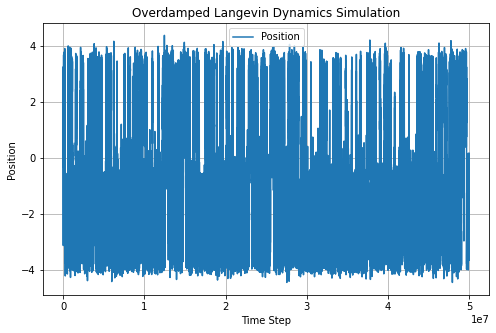

In [17]:
# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(np.arange(steps), positions_overdamped, label="Position")
plt.xlabel("Time Step")
plt.ylabel("Position")
plt.title("Overdamped Langevin Dynamics Simulation")
plt.legend()
plt.grid(True)
plt.show()

It can be observed that the system again explores both minima with transitions between the left and right state.

In the following Histogram the distribution of the Overdamped Langevin can be compared to the morkovian langevin as well as the Boltzmann distribution.

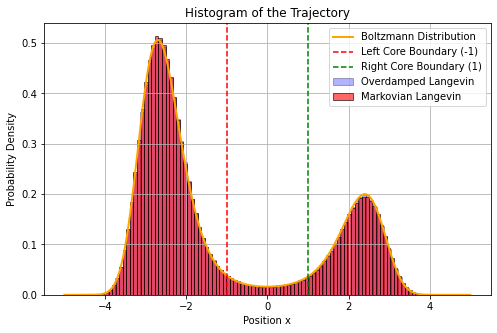

In [18]:
# Plot histogram of the trajectory

plt.figure(figsize=(8, 5))
# Histogram of Overdamped Langevin
plt.hist(positions_overdamped, bins=100, density=True, label="Overdamped Langevin",
         color="blue", alpha=0.3, edgecolor="black")

# Histogram of Markovian Langevin
plt.hist(positions_markovian, bins=100, density=True, label="Markovian Langevin",
         color="red", alpha=0.6, edgecolor="black")

# Plot Boltzmann Distribution for reference
plt.plot(x, P_x, label="Boltzmann Distribution", color="orange", linewidth=2)

# Mark core state boundaries
plt.axvline(-1, color="red", linestyle="--", label="Left Core Boundary (-1)")
plt.axvline(1, color="green", linestyle="--", label="Right Core Boundary (1)")

plt.xlabel("Position x")
plt.ylabel("Probability Density")
plt.title("Histogram of the Trajectory")
plt.legend()
plt.grid(True)
plt.show()

As with the markovian langevin simulation now states are assigned, the quick statistics analysis is performed, and transition rates are calculated.

In [19]:
states_overdamped = assign_core_states(positions_overdamped)

left_count_overdamped, right_count_overdamped = quick_statistics_check(states_overdamped, verbose=True)

Left states (0): 35144523 = 70.289046%
Right states (1): 14855477 = 29.710954%
Total states: 50000000
Check if both add up correctly: Yes


In [20]:
# Transition Rates
k_left_to_right_overdamped,k_right_to_left_overdamped = compute_transition_rates(states_overdamped, left_count_overdamped, right_count_overdamped, verbose=True)

Transition rate k(left -> right): 0.00592 per ps
Transition rate k(right -> left): 0.01400 per ps


The transition rates between the markovian Langevin and overdamped Langevin Simulation can be compared.

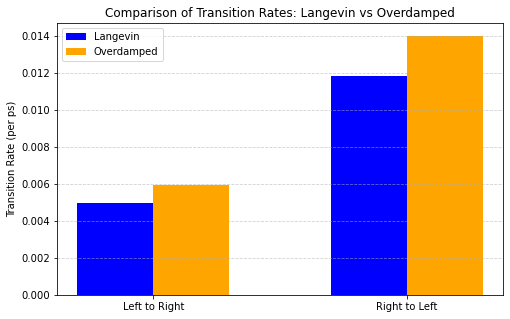

In [21]:

# store variables from above as lists for simple visualisation
types = ["Left to Right", "Right to Left"]
langevin_rates = [k_left_to_right_langevin, k_right_to_left_langevin]
overdamped_rates = [k_left_to_right_overdamped, k_right_to_left_overdamped]

# Plot comparison
x = np.arange(len(types))  # Bar positions
width = 0.3  # Width of the bars

plt.figure(figsize=(8, 5))
plt.bar(x - width / 2, langevin_rates, width=width, label="Langevin", color="blue")
plt.bar(x + width / 2, overdamped_rates, width=width, label="Overdamped", color="orange")

# Labels and Titles
plt.xticks(x, types)
plt.ylabel("Transition Rate (per ps)")
plt.title("Comparison of Transition Rates: Langevin vs Overdamped")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Show plot
plt.show()

And finally for task 3 an exemplary trajectory of a particle is show.

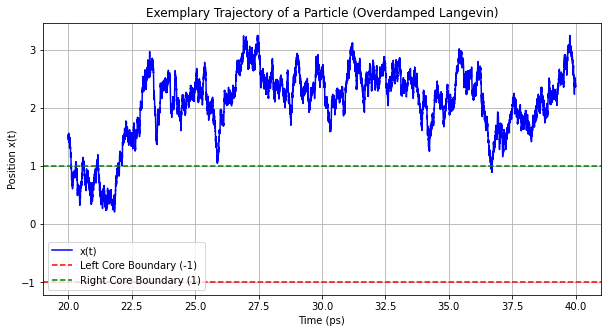

In [22]:
# Define example trajectory interval
start_index = 20000
end_index = 40000

# Generate time array
time_array = np.arange(start_index, end_index) * dt

# Plot the trajectory
plt.figure(figsize=(10, 5))
plt.plot(time_array, positions_overdamped[start_index:end_index], label="x(t)", color="blue")

# Mark core state boundaries
plt.axhline(-1, color="red", linestyle="--", label="Left Core Boundary (-1)")
plt.axhline(1, color="green", linestyle="--", label="Right Core Boundary (1)")

plt.xlabel("Time (ps)")
plt.ylabel("Position x(t)")
plt.title("Exemplary Trajectory of a Particle (Overdamped Langevin)")
plt.legend()
plt.grid(True)
plt.show()

**Task 3: Compare Langevin Equations**

In the last step both Langevin equations will be run for different friction coefficients $\Gamma$ ranging from 75 down to 10.

The calculated transition rates $k_{i \rightarrow j}$ will be compared with the theoretical formula

$
k_{i \to j}(\Gamma) \approx \frac{\omega_i \omega_{\text{max}}}{2 \pi \Gamma} e^{-\frac{U(x_{\text{max}}) - U(x_i)}{k_B T}}
$

with $\omega_i^2 = \frac{d^2 U (x_i)}{dx^2}$ and $\omega_\mathrm{max}^2 = - \frac{d^2 U (x_\mathrm{max}) - U (x_i)}{dx^2}$.


Next run langevin for different gammas:

In [23]:
# Define range of gamma values to test
gamma_values = np.array([ 100, 75, 55, 40, 30, 15, 10])  # Different damping values

# Store transition rates
k_left_to_right_markovian = []
k_right_to_left_markovian = []
k_left_to_right_overdamped = []
k_right_to_left_overdamped = []

for gamma in gamma_values:
    print(f"\n**** Running simulations for gamma = {gamma}")

    # Run Task 1 (Markovian Langevin)
    print(f'Running Markovian Langevin Simulation')

    positions_markovian, velocities_markovian = langevin_integrator(steps, dt, x0, v0, mass, gamma, k_B_x_T, verbose=False)
    states_markovian = assign_core_states(positions_markovian)
    left_count_m, right_count_m = quick_statistics_check(states_markovian, verbose=False)
    k_m_left, k_m_right = compute_transition_rates(states_markovian, left_count_m, right_count_m, verbose=False)

    print(f'transition rates: {k_m_left, k_m_right}')

    k_left_to_right_markovian.append(k_m_left)
    k_right_to_left_markovian.append(k_m_right)

    # Run Task 2 (Overdamped Langevin)
    print(f'Running Overdamped Langevin Simulation')
    positions_overdamped = overdamped_langevin_integrator(steps, dt, x0, mass, gamma, k_B_x_T, verbose=False)
    states_overdamped = assign_core_states(positions_overdamped)
    left_count_o, right_count_o = quick_statistics_check(states_overdamped, verbose=False)
    k_o_left, k_o_right = compute_transition_rates(states_overdamped, left_count_o, right_count_o, verbose=False)

    print(f'transition rates: {k_o_left, k_o_right}')

    k_left_to_right_overdamped.append(k_o_left)
    k_right_to_left_overdamped.append(k_o_right)


**** Running simulations for gamma = 100
Running Markovian Langevin Simulation
transition rates: (0.004372477077288922, 0.011660163009078866)
Running Overdamped Langevin Simulation
transition rates: (0.005160560086850393, 0.016573862899822246)

**** Running simulations for gamma = 75
Running Markovian Langevin Simulation
transition rates: (0.007009115932325719, 0.017202268626896264)
Running Overdamped Langevin Simulation
transition rates: (0.006949291226312515, 0.015109285525691721)

**** Running simulations for gamma = 55
Running Markovian Langevin Simulation
transition rates: (0.00974992467963592, 0.021014913015299234)
Running Overdamped Langevin Simulation
transition rates: (0.010778782741896295, 0.023747589058112212)

**** Running simulations for gamma = 40
Running Markovian Langevin Simulation
transition rates: (0.011459844858478658, 0.02802960506217429)
Running Overdamped Langevin Simulation
transition rates: (0.013959545237900564, 0.03452079064974171)

**** Running simulations 

now calculate theoretical transition rates for each gamma.

Since there are two states: left and right each one will be assigned the x position of its minimum. Thus, the state left is assigned x = -2.7 (calculated manually, see above) and right x = 2.4. The below code calculates the theoretical transition rates.

In [24]:

def theoretical_transition_rate(gamma, omega_i, omega_max, U_max, U_i, k_B_x_T):
    return (omega_i * omega_max) / (2 * np.pi * gamma) * np.exp(-(U_max - U_i) / k_B_x_T)

def omega_i(x_i, k_B_x_T):
    omega_i_squared = ddU_ddx(x_i, k_B_x_T)
    return np.sqrt(omega_i_squared)

def omega_max(x_max, k_B_x_T):
    omega_max_squared = -ddU_ddx(x_max, k_B_x_T)
    return np.sqrt(omega_max_squared)

# Define parameters (calculated manually)
x_left = -2.7
x_right = 2.4
x_max = 0  # Barrier location

# Compute potential values
U_max = U(x_max, k_B_x_T)
U_left = U(x_left, k_B_x_T)
U_right = U(x_right, k_B_x_T)


# Compute transition rates
k_left_to_right_theoretical = []
k_right_to_left_theoretical = []

for gamma in gamma_values:
    k_lr = theoretical_transition_rate(gamma, omega_i(x_left, k_B_x_T), omega_max(x_max, k_B_x_T), U_max, U_left, k_B_x_T)
    k_rl = theoretical_transition_rate(gamma, omega_i(x_right, k_B_x_T), omega_max(x_max, k_B_x_T), U_max, U_right, k_B_x_T)

    k_left_to_right_theoretical.append(k_lr)
    k_right_to_left_theoretical.append(k_rl)

    print(f"Gamma = {gamma}: k_left_to_right = {k_lr:.5f}, k_right_to_left = {k_rl:.5f}")



Gamma = 100: k_left_to_right = 0.00511, k_right_to_left = 0.01218
Gamma = 75: k_left_to_right = 0.00681, k_right_to_left = 0.01624
Gamma = 55: k_left_to_right = 0.00928, k_right_to_left = 0.02215
Gamma = 40: k_left_to_right = 0.01276, k_right_to_left = 0.03046
Gamma = 30: k_left_to_right = 0.01702, k_right_to_left = 0.04061
Gamma = 15: k_left_to_right = 0.03404, k_right_to_left = 0.08122
Gamma = 10: k_left_to_right = 0.05106, k_right_to_left = 0.12183


visualise

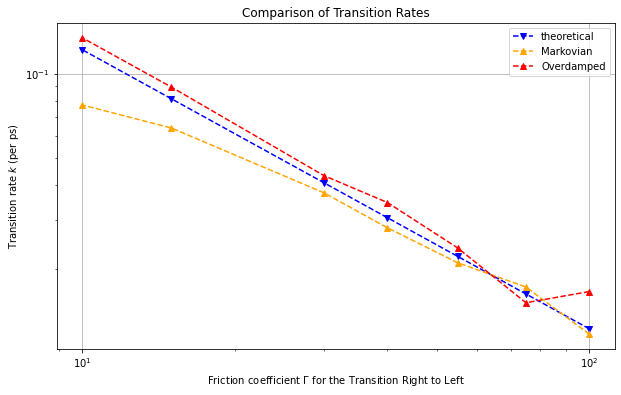

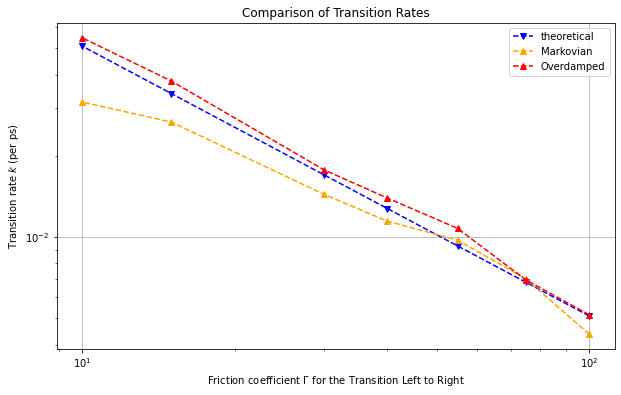

In [28]:
# plot transition right to left
plt.figure(figsize=(10, 6))

plt.plot(gamma_values, k_right_to_left_theoretical, 'v--', label="theoretical", color="blue")
plt.plot(gamma_values, k_right_to_left_markovian, '^--', label="Markovian", color="orange")
plt.plot(gamma_values, k_right_to_left_overdamped,'^--', label="Overdamped", color="red")

plt.xlabel(r'Friction coefficient $\Gamma$ for the Transition Right to Left')
plt.ylabel(r'Transition rate $k$ (per ps)')
plt.title('Comparison of Transition Rates')
plt.legend()
plt.xscale('log')  # Log scale for better visualization
plt.yscale('log')  # Log scale for better comparison

plt.grid()
plt.show()


# Plot transition left to right
plt.figure(figsize=(10, 6))

plt.plot(gamma_values, k_left_to_right_theoretical, 'v--', label="theoretical", color="blue")
plt.plot(gamma_values, k_left_to_right_markovian, '^--', label="Markovian", color="orange")
plt.plot(gamma_values, k_left_to_right_overdamped,'^--', label="Overdamped", color="red")

plt.xlabel(r'Friction coefficient $\Gamma$ for the Transition Left to Right')
plt.ylabel(r'Transition rate $k$ (per ps)')
plt.title('Comparison of Transition Rates')
plt.legend()
plt.xscale('log')  # Log scale for better visualization
plt.yscale('log')  # Log scale for better comparison

plt.grid()
plt.show()

From the above comparison we can see...

In [26]:
# example of how to use sumpy to determine minimas, maximas, differentiation etc.

import sympy as sp

# Define the variable
x = sp.Symbol('x', real=True)

# Define the function
f = 38 * (0.28 * (0.25 * x**4 + 0.1 * x**3 - 3.24 * x**2) + 3.5)

# Compute the first derivative
f_prime = sp.diff(f, x)

# Solve for critical points (where f' = 0)
critical_points = sp.solve(f_prime, x)

# Compute the second derivative
f_double_prime = sp.diff(f_prime, x)

# Determine which critical points correspond to local maxima
local_maxima = [point.evalf() for point in critical_points if f_double_prime.subs(x, point) < 0]

# Display the local maxima
print(f" local maximum at x = {local_maxima}")

 local maximum at x = [0]


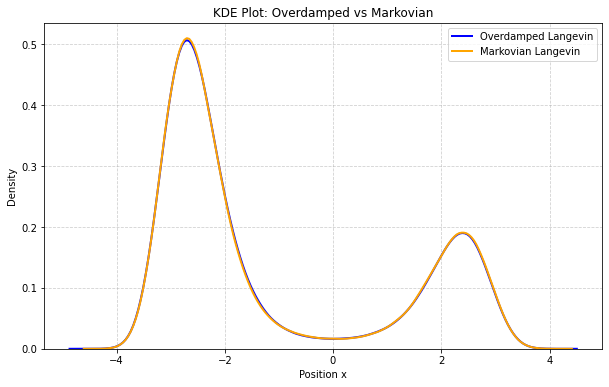

In [31]:
# KDE PLOT to better see how similar the two simulations are. Carefull this takes quite long.

import seaborn as sns

plt.figure(figsize=(10, 6))

sns.kdeplot(positions_overdamped, label="Overdamped Langevin", color="blue", linewidth=2)
sns.kdeplot(positions_markovian, label="Markovian Langevin", color="orange", linewidth=2)

plt.xlabel("Position x")
plt.ylabel("Density")
plt.title("KDE Plot: Overdamped vs Markovian")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

plt.show()